El siguiente notebook es una implementación básica de una CNN para la clasificación de imágenes. Utiliza el dataset CIFAR-10 y una red convolucional de dos capas.

El objetivo es entender cómo los hiperparámetros y el 'data augmentation' afectan el entrenamiento del modelo, esto se observa a través de las curvas de la función de pérdida (y otras métricas) en función de las épocas de entrenamiento.

El primer modelo entrenado usa 'data augmentation', se puede observar un aprendizaje estable y sin overfitting (al observar los datos de validación). El segundo modelo, utiliza los mismos hiperparámetros pero sin data augmentation durante el entrenamiento, lo que resulta en un sobreajuste muy marcado.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

Ver el dataset

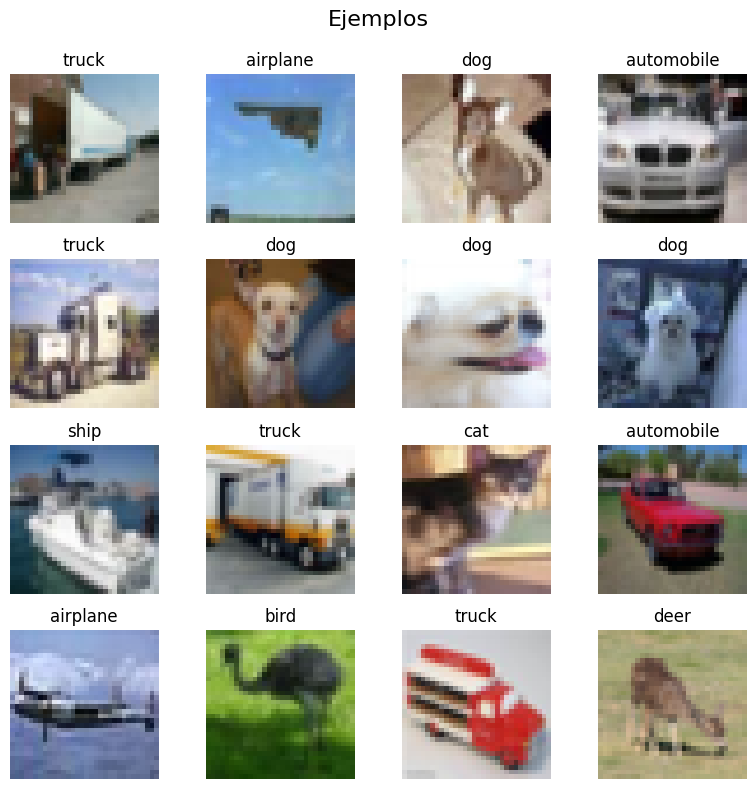

In [ ]:
# convierte las imagenes en tensor
raw_transform = transforms.ToTensor()

# Cargar el dataset con solo ToTensor
raw_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=raw_transform)
raw_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=16, shuffle=True)

# Obtener un batch de imágenes sin normalizar
images, labels = next(iter(raw_loader))
classes = raw_dataset.classes

# Mostrar las imágenes en una cuadrícula
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Ejemplos", fontsize=16)

for i in range(16):
    img = images[i].numpy()
    img = np.transpose(img, (1, 2, 0))  # de [C,H,W] a [H,W,C]
    ax = axes[i // 4, i % 4]
    ax.imshow(img)
    ax.set_title(classes[labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Data augmentation

Note que las imágenes de entrenamiento se cargan con dos transformaciones (RandomHorizontalFlip y RandomCrop), mientras que las imágenes de prueba no tienen ninguna tranformación (salvo la normalización en el rango [-1,1]). Esto puede provocar que la curva de validación sea mejor que la de entrenamiento.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

carga de batches

In [ ]:
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = trainset.classes

Definimos el modelo. Tiene dos capas, uno de 32 filtros y otro de 64, todos 3x3. Además de Relu, MaxPool y una pequeña red densa con 128 y 10 neuronas. También se usa Dropout.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # [B, 3, 32, 32] → [B, 32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # → [B, 32, 16, 16]
            nn.Conv2d(32, 64, 3, padding=1), # → [B, 64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)               # → [B, 64, 8, 8]
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)


Definimos cómo se va a entrenar y evaluar el modelo. Se calculará la función de pérdida CrossEntropyLoss y el accuracy (predicciones correctas sobre total de predicciones).

Importante: Se define el learning rate (lr) y el optimizador a usar. Los modelos son muy sensibles a estas elecciones. Puede jugar con el lr y ver cómo cambia el entrenamiento del modelo.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

def evaluate(loader):
    model.eval()
    total, correct, loss_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = loss_total / total
    accuracy = correct / total
    return avg_loss, accuracy

Entrenamos el modelo durante 40 épocas. Usted puede cambiar este número.

In [ ]:
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(testloader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/40 - Train loss: 1.5831, Acc: 0.4165 | Val loss: 1.2255, Acc: 0.5614
Epoch 2/40 - Train loss: 1.2944, Acc: 0.5333 | Val loss: 1.0626, Acc: 0.6222
Epoch 3/40 - Train loss: 1.1782, Acc: 0.5807 | Val loss: 0.9665, Acc: 0.6641
Epoch 4/40 - Train loss: 1.1133, Acc: 0.6038 | Val loss: 0.9182, Acc: 0.6776
Epoch 5/40 - Train loss: 1.0661, Acc: 0.6224 | Val loss: 0.8637, Acc: 0.6994
Epoch 6/40 - Train loss: 1.0319, Acc: 0.6367 | Val loss: 0.8425, Acc: 0.7082
Epoch 7/40 - Train loss: 0.9982, Acc: 0.6514 | Val loss: 0.8396, Acc: 0.7060
Epoch 8/40 - Train loss: 0.9810, Acc: 0.6561 | Val loss: 0.7981, Acc: 0.7205
Epoch 9/40 - Train loss: 0.9657, Acc: 0.6627 | Val loss: 0.8168, Acc: 0.7101
Epoch 10/40 - Train loss: 0.9350, Acc: 0.6734 | Val loss: 0.7914, Acc: 0.7273
Epoch 11/40 - Train loss: 0.9345, Acc: 0.6742 | Val loss: 0.8042, Acc: 0.7195
Epoch 12/40 - Train loss: 0.9158, Acc: 0.6813 | Val loss: 0.7779, Acc: 0.7319
Epoch 13/40 - Train loss: 0.9070, Acc: 0.6832 | Val loss: 0.7579, Acc: 0.

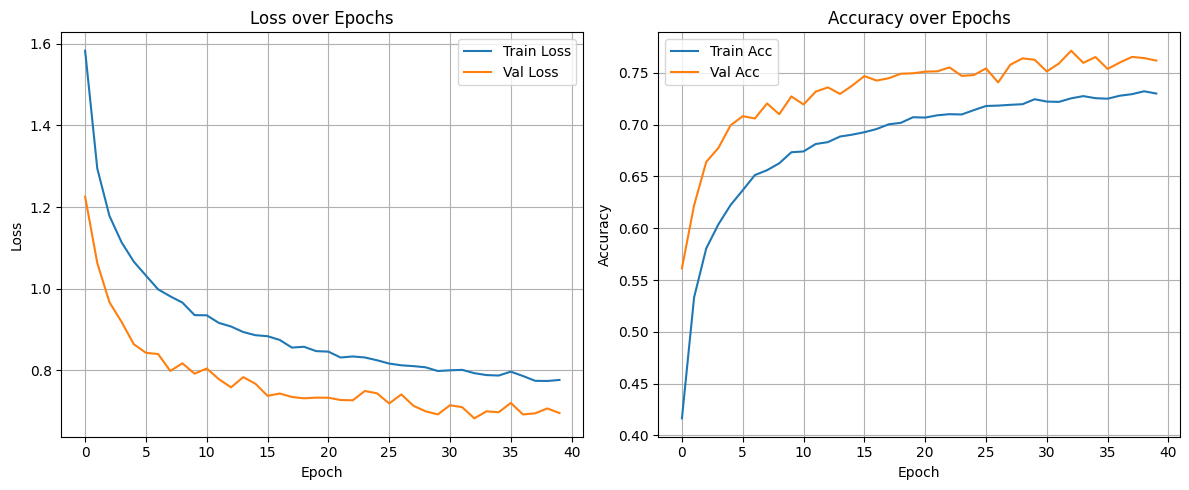

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Sin data augmentation

Repetimos todo pero esta vez no utilizaremos data augmentation. Note la enorme diferencia entre las curvas obtenidas.

Epoch 1/40 - Train loss: 1.4469, Acc: 0.4766 | Val loss: 1.1366, Acc: 0.5931
Epoch 2/40 - Train loss: 1.0970, Acc: 0.6093 | Val loss: 0.9563, Acc: 0.6622
Epoch 3/40 - Train loss: 0.9588, Acc: 0.6633 | Val loss: 0.9226, Acc: 0.6769
Epoch 4/40 - Train loss: 0.8550, Acc: 0.6995 | Val loss: 0.8546, Acc: 0.7005
Epoch 5/40 - Train loss: 0.7730, Acc: 0.7282 | Val loss: 0.8139, Acc: 0.7205
Epoch 6/40 - Train loss: 0.7115, Acc: 0.7473 | Val loss: 0.8089, Acc: 0.7182
Epoch 7/40 - Train loss: 0.6470, Acc: 0.7699 | Val loss: 0.8218, Acc: 0.7203
Epoch 8/40 - Train loss: 0.5898, Acc: 0.7917 | Val loss: 0.8048, Acc: 0.7317
Epoch 9/40 - Train loss: 0.5427, Acc: 0.8042 | Val loss: 0.8416, Acc: 0.7253
Epoch 10/40 - Train loss: 0.4999, Acc: 0.8196 | Val loss: 0.8418, Acc: 0.7208
Epoch 11/40 - Train loss: 0.4596, Acc: 0.8340 | Val loss: 0.8780, Acc: 0.7242
Epoch 12/40 - Train loss: 0.4241, Acc: 0.8450 | Val loss: 0.8997, Acc: 0.7295
Epoch 13/40 - Train loss: 0.3914, Acc: 0.8567 | Val loss: 0.9623, Acc: 0.

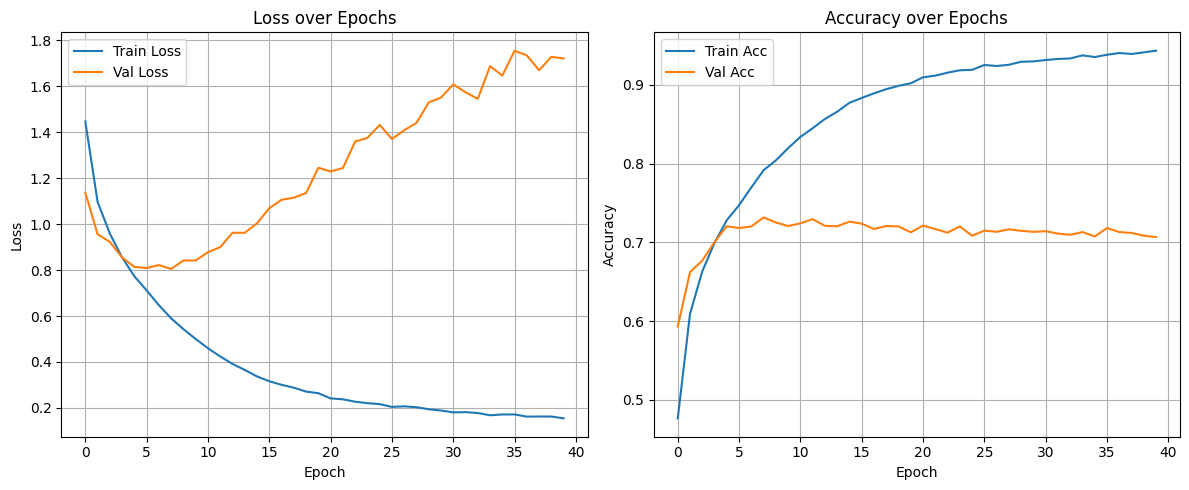

In [ ]:
No_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=No_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=No_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = trainset.classes

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # [B, 3, 32, 32] → [B, 32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # → [B, 32, 16, 16]
            nn.Conv2d(32, 64, 3, padding=1), # → [B, 64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)               # → [B, 64, 8, 8]
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

def evaluate(loader):
    model.eval()
    total, correct, loss_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = loss_total / total
    accuracy = correct / total
    return avg_loss, accuracy

epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(testloader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()